<img src="https://justaklikaway.files.wordpress.com/2014/05/shut-up-and-take-my-money.jpg" height="400" width="400"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 1: продажи </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Первой такой аркой будут продажи. Им будет посвящена первая серия из семинаров и домашек. 


#  Эпизод II (атака моделей) 

В этом эпизоде мы с вами попробуем взять уже предобработанные данные и натравим на них модели. Ох! Ну и жара же сейчас пойдёт.

## Задача 

В первой части нашего курса мы с вами будем обсуждать такой сюжет, как продажи. Будем стараться их спрогнозировать. Повторите семинары по регрессии из прошлого семестра. Мы будем пользоваться знаниями, которые там получили. Сегодня занимаемся моделированием. В следущий раз занимаемся оценкой бизнес-эффекта от наших моделей. 

In [1]:
# Как обычно, для начала подгружаем нужные нам пакеты
import pandas as pd    # пакет для работы с таблицами 
import numpy as np     # пакет для работы с матрицами 

# пакеты для картиночек 
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков

%matplotlib inline

## Что уже есть? 

В прошлый раз мы поговорили о том, зачем надо вдруг кому-то предсказывать продажи и собрали для этих целей датасет по данным walmart. 

In [3]:
df = pd.read_csv('../sem1_data_prepare/sales_train_v1.tsv', sep='\t')    # подгружаем датасет
print('Размерность таблицы:', df.shape)      # shape показывает его размер
df.head()                    

Размерность таблицы: (343650, 148)


,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Black_Friday,Pre_christmas
0,24924.50,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,1,0,0,0,0,0,0,0,0,0
1,46039.49,151315,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,...,1,0,0,0,0,0,0,0,0,0
2,41595.55,151315,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,...,1,0,0,0,0,0,0,0,0,0
3,19403.54,151315,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,...,1,0,0,0,0,0,0,0,0,0
4,21827.90,151315,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,...,0,1,0,0,0,0,0,0,0,0


## 1. Метрики 

В прошлои семестре мы с вами обсуждали довольно много разных метрик для задачи регрессии. Говорили о разнице между ними и где какую лучше использовать. Помните? Или уже забыли? Если забыли, бегом вспоминать в материалы предыдущего модуля! 

------------------

Мы при решении задачи будем использовать MAE и RMSE. Давайте напишим небольшую функцию, с помощью которой нам будем немного удобнее выводить эти две метрики на экран.

In [4]:
from sklearn import metrics  # подгружаем метрики

# функция, которая считает метрики и выводит их на экран
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    pass

# пример:
y_test = [1,2,3,4]
y_pred = [1,1,1,1]
print_metrics(y_test,y_pred)

MAE: 1.5
RMSE: 1.8708286933869707


## 2. Тренировочная и тестовая выборки 

Разбиваем выборку на две части. Кстати говоря, зачем мы это делаем?! 

In [5]:
# это то, что мы пытаемся прогнозировать! 
y = df['ln_future_sales']
 
# то, по чему пытаемся прогнозировать, ln_Weekly_Sales оставили!
df = df.drop(['ln_future_sales', 'future_sales', 'Weekly_Sales'], axis=1)
X = df.get_values()

# Запомним на всякий случй имена всех переменных 
feature_names = df.columns

Будем бить по классике. На самом деле, в данных есть временная структура. Мы, в таком разбиении её игнорируем, предполагая, что наблюдения не зависят от времени. Это не совсем правда. Работе с временными рядами в анализе данных посвящена отдельная огромная область. В неё мы не полезем.

In [6]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 70 к 30
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size = 0.3)

## 3. Наивный прогноз 

Что такое наивный прогноз небось тоже забыли? Именно его мы построим для наших данных первым делом. Будем говорить, что продажи в любом магазине совпадают со средним значением. Это самый глупый прогноз, который мы можем сделать. С ним мы будем сравнивать прогнозы более сложных моделей. 

In [7]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им продажи
y_pred_naive[:5]

array([8.53423956, 8.53423956, 8.53423956, 8.53423956, 8.53423956])

In [8]:
# та самая функция, которую мы сделали в самом начале тетрадки
print_metrics(y_test, y_pred_naive)

MAE: 1.517693725054783
RMSE: 2.0018474408566513


Можно посмотреть на ошибку не в $\ln(money)$, а в $money$!

In [9]:
print_metrics(np.exp(y_test), np.exp(y_pred_naive))

MAE: 13665.008935081125
RMSE: 25333.644853343278


## 4. Линейная регрессия 

Пришло время построить линейную регрессию! Эта модель говорит, что объём продаж формируется в результате суммирования тех характеристик, которыми обладает магазин с какими-то весами

$$
y = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.
$$

Например, если мы оценили модель и у нас получилось, что 

$$ sales = 10000 + 20 \cdot t,$$

то это означает, что средний объём продаж равен 10 тыс. рублей. При этом каждый дополнительный градус температуры на улице, в среднем, при прочих равных, увеличивает объёмы продаж на 20 рублей. 

Для того, чтобы подобрать коэффициенты обычно минимизируют MSE. Сегодня мы проделаем это на компьютере, в следущий раз проделаем это руками прямо на доске. 

In [10]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_reg = LinearRegression()

# Обучили модель на тренировочной выборке 
model_reg.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_reg = model_reg.predict(X_test)

Посмотрим на ошибку прогноза на тестовой выборке.

In [12]:
# в логарифмах денег
print_metrics(y_test, y_pred_reg)

MAE: 0.22407318807889276
RMSE: 0.4403252843174308


In [13]:
# в деньгах
print_metrics(np.exp(y_test), np.exp(y_pred_reg))

MAE: 2158.8673744465964
RMSE: 6358.393729150839


По сравнению с наивным прогнозом, она довольно сильно упала. Кажется, что за счёт этой модели мы можем каким-то образом сэкономить денег. Правда пока что не очень понятно как именно.  Кстати говоря, для того, чтобы смотреть насколько хорошими, в случае регрессии, получились прогнозы, можно строить такие вот картинки. 

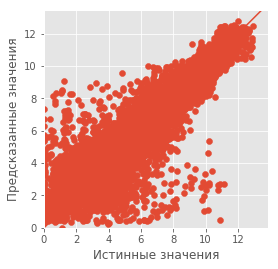

In [15]:
plt.scatter(y_test, y_pred_reg)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Если все точки на диагонали, значит наша модель строит очень хорошие предсказания. Такую же можно построить и для тренировочной выборки. 

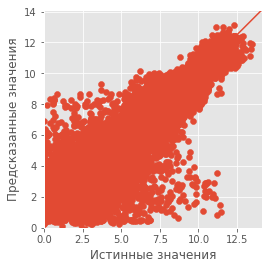

In [16]:
plt.scatter(y_train, model_reg.predict(X_train))
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Если вдруг окажется, что на тренировочных данных прогнозы чётко лежат на диагонали, а на тестовой выборке полный хаос, значит мы переобчуились. Если, конечно, мы не имеем дело со случайным лесом. __Случайный лес не переобучается.__ Или про это вы уже тоже забыли? 

Посмотрим на то, какие признаки вносят в продажи наибольший вклад. 

In [17]:
model_reg.coef_  # коэффициенты модели

array([ 5.67743450e-07,  2.72891152e-04,  5.89311156e-03, -2.86250075e-08,
       -4.48816040e-06, -1.16842188e-06,  1.46824274e-06,  2.06029578e-06,
       -1.27950902e-03,  5.09065618e-03,  9.30730949e-01,  1.12660356e-02,
       -2.03157931e-03,  2.86977633e-03, -1.02981794e-02, -1.70423276e-03,
        2.83145521e-03,  4.71058399e-02, -9.74435953e-02,  4.37549861e-02,
       -3.26669155e-04,  1.63641209e-02, -1.24670275e-02,  3.07628859e-02,
       -9.41125254e-03, -1.89934996e-02, -7.60140373e-02, -1.08306601e-01,
       -3.99134369e-02, -6.72742675e-02,  2.70004486e-02, -2.42605812e-02,
       -2.79140780e-02, -1.21588020e-01,  5.65366923e-03,  4.06206357e-02,
       -3.42137301e-02,  1.96865330e-02, -1.38017253e-01,  4.02771806e-02,
       -1.33657667e-01, -1.01503872e-01, -1.64634386e-01, -7.90336046e-02,
        2.92987197e-02, -4.63881605e-02, -6.72686502e-02, -2.64680224e-01,
       -1.52133518e-01, -3.47254839e-02, -1.04209869e-01,  5.01595441e-02,
       -1.16909744e-01, -

In [18]:
featureImportance = pd.DataFrame({"feature": feature_names,  "importance": model_reg.coef_})
featureImportance.head()

,feature,importance
0,Size,5.677434e-07
1,Temperature,2.728912e-04
2,Fuel_Price,5.893112e-03
3,MarkDown1,-2.862501e-08
4,MarkDown2,-4.488160e-06


In [19]:
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance.head()

,importance
feature,
ln_Weekly_Sales,0.930731
Dept_95,0.353736
Dept_38,0.350014
Dept_92,0.349452
Dept_40,0.323930


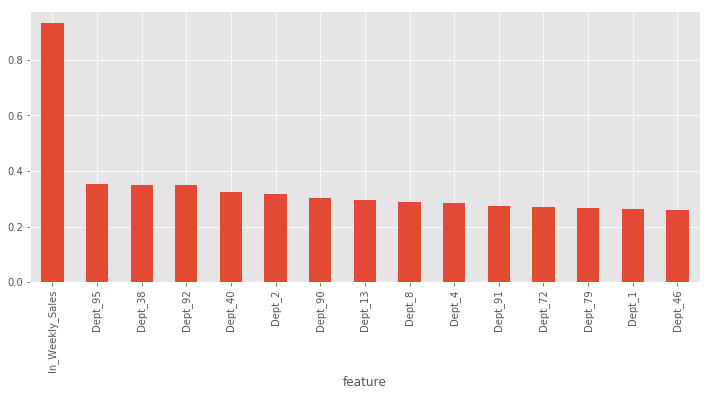

In [20]:
featureImportance["importance"][:15].plot('bar', figsize=(12,5));

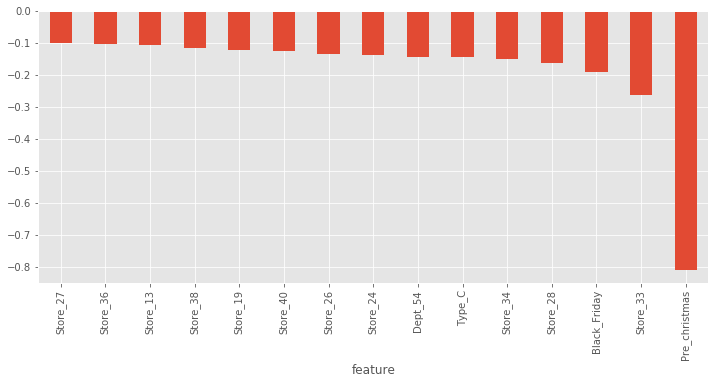

In [21]:
featureImportance["importance"][-15:].plot('bar', figsize=(12,5));

Почему рождество и чёрная пятница оказались с отрицательными весами? Ответ простой: при предобработке мы сделали ошибку. Мы прогнозируем спрос на завтра. Рождество сегодня. Значит завтра спрос сильно упадёт. Так и просходит в модели. Чтобы дамми, наложенная на рождество оказалась положительной, нам надо было сдвинуть её по времени на единицу, чего мы не сделали. 

__Мораль:__ если вы видите, что модель себя ведёт странно, возможно, был сделан косяк при предобработке данных. 

## 5. Кросс-валидация 

Главная задача обучаемых алгоритмов – их способность обобщаться, то есть хорошо работать на новых данных. Поскольку на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели. Чаще всего это делается одним из 2 способов:


* отложенная выборка __(held-out/hold-out set).__ При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели. Сейчас мы сделали именно так. У этого подхода есть минусы. Результат работы модели может сильно зависеть от конкретного разбиения. Хочется убить эту зависиомсть. Для этого используют кросс-валидацию. 

* кросс-валидация __(cross-validation, на русский еще переводят как скользящий или перекрестный контроль).__ Тут самый частый случай – K-fold кросс-валидация



<img src="https://hsto.org/files/b1d/706/e6c/b1d706e6c9df49c297b6152878a2d03f.png" height="600" width="600"> 


Модель обучается $K$ раз на разных подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет). Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регрессии на кросс-валидации. 

Кросс-валидация дает лучшую, по сравнению с отложенной выборкой, оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много.
 
Кросс-валидация – очень важная техника в машинном обучении, с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д.

Попробуем посмотреть на качество нашей регрессии на кросс-валидации.

In [22]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()

mse_val = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_val

array([-0.18638047, -0.19313277, -0.18995071, -0.19369237, -0.1866402 ])

In [23]:
np.mean(np.sqrt(-1*mse_val))

0.43582876895489936

## 6 Регуляризация

Теперь мы умеем оценивать линейную регрессию и смотреть на её качество по кросс-валидации. Пришло время переходить к более сложным моделям. Давайте посмотрим на Lasso-регрессию. Для начала просто оценим её. Потом уже будем смотреть на то, чем она лучше обычной. 

In [24]:
from sklearn.linear_model import Lasso  # подгрузили модель

# Объявили модель
model_simplelasso = Lasso(alpha = 10)

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

In [25]:
print_metrics(y_test,y_pred_lasso)

MAE: 1.4443236114061506
RMSE: 1.8964852547471927


Посмотрим на коэффициенты модели. 

In [26]:
model_simplelasso.coef_

array([ 1.05097926e-05, -0.00000000e+00, -0.00000000e+00,  2.68845113e-06,
       -2.50965659e-06,  1.89901878e-06, -4.75675417e-07,  9.56594496e-06,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

Огромное количество нулей. Как так получилось?  Дело в том, что Lasso-регрессия отличается от обычной специальным штрафом: __регуляризацией.__ В течение всего предыдущего курса мы говорили, что модели часто страдают таким недугом, как переобучение. 

![](https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2015/05/mlconcepts_image51.png)

В случае регрессии это выражается в том, что линия, которую мы проводим, слишком подробно вылизывает точки пространства. На самой правой каритинке именно это и произошло. Для того, чтобы так подробно опутать точки, регрессии надо делать очень резкие повороты. Для резких поворотов ей необходимы большие коэффициенты. 

Получается, что если мы хотим избежать резких поворотов, и значит, переобучения, нам нужно накладывать на коэффициенты специальные штрафы, которые не дадут им становиться очень-очень большими. Как можно оштрафовать коэффициенты за их размер? Очень просто. Давайте возьмём нашу функцию ошибки, $MSE$, и прибавим к ней дополнительное слагаемое. 

$$MSE + \alpha \cdot \sum |\beta|.$$ 

Теперь мы будем минимизировать не просто квадрат ошибки, а квадрат ошибки плюс сумму модулей коэффициентов. Этот приём не даст нашей модели переобучится. 

Обратите внимание, что штраф мы вносим с весом $\alpha$. Если взять $\alpha = 1000$, то мы говорим, что очень сильно хотим штрафовать коэффициенты за их размер. Если мы берём $\alpha = 1$, мы говорим, что хотим внести мааааааленький штраф. В нашем случае штраф получился равен $100$. Оказалось, что это довольно много и огромное число коэффициентов занулилось. Качество модели упало. 

Кроме модулей коэффициентов, можно добавлять штраф из квадратов коэффициентов 

$$MSE + \alpha \cdot \sum \beta^2.$$ 

Такая модель называется redge-регрессией (гребневой регрессией).

Возникает вопрос: а надо ли нам вообще в случае наших продаж боятся переобучения и подбирать $\alpha$? Не очень понятно. Чтобы разобраться обычно пробуют много разных значений $\alpha$ и ищут такое, чтобы ошибка на кросс-валидации стала поменьше.  Делается это с помощью специального метода: `GridSearch`, поиска по решётке. Такие параметры, как $\alpha$, которые можно покрутить и посмотреть что изменится, называются __гиперпараметрами модели.__ 

In [27]:
%%time
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор, cv=5 это количество фолдов для валидации
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5, scoring='neg_mean_squared_error')

# обучаем решётку
grid_cv_lasso.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 24 s, total: 2min 50s
Wall time: 2min 29s


Перебор работает очень долго. Для каждого `alpha` нам надо учить `cv` моделей. Всего получается в нашей ситуции учится $9 \cdot 5 = 45$ моделей. Параметров для перебора в моделях бывает много. Обычно поиск по решётке используют в случае $1,2$, ну максимум $3$ параметров.

In [28]:
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)
print('Лучшее качество:', grid_cv_lasso.best_score_)

Лучшее значение параметра: {'alpha': 0.001}
Лучшее качество: -0.19395653731843174


In [29]:
np.sqrt(-1*grid_cv_lasso.best_score_)

0.4404049696795345

In [30]:
model_lasso = grid_cv_lasso.best_estimator_

# Сделали прогнозы
y_pred_lasso = model_lasso.predict(X_test)

In [31]:
print_metrics(y_test, y_pred_lasso)

MAE: 0.22306035862080364
RMSE: 0.4452814862126029


Лучшее `alpha` оказалось очень маленьким. Значит модели не нужна регуляризация. Это хорошая новость. Проблемы начнутся позже, в домашке. 

## 6. Случайный лес 

Напоследок давайте попробуем натравить на данные более сложную модель, случайный лес. Вы же ещё не забыли как строятся деревья?  В случае случайного леса они строятся максимально независимо по разным подвыборкам из нашей большой таблички. Каждое дерево даёт нам прогноз, потом мы берём весь лес и усредняем по нему прогнозы. В итоге получается один коллективный прогноз. 

Ясное дело, что лес будет учиться намного дольше обычной регрессии из-за того, что под капотом леса работает жадный алгоритм. Мы должны попробовать сделать разбиение в каждой вершине дерева в куче разных мест и посмотреть что будет. Помните мы руками на доске учили деревья? Не помните? Уже забыли? Ну и балбесы! Ой, всё. 

In [32]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Объявили лес из 100 деревьев 
rf = RandomForestRegressor(n_estimators=100)

# Обучили лес 
rf.fit(X_train, y_train)

# Сделали по лесу прогнозы 
y_pred_forest = rf.predict(X_test)

CPU times: user 18min 24s, sys: 9.7 s, total: 18min 34s
Wall time: 18min 38s


Смотрим на прогнозные метрики. 

In [33]:
print_metrics(y_test, y_pred_forest)

MAE: 0.2108135137887035
RMSE: 0.41188050277583305


Они же, но в деньгах. 

In [34]:
print_metrics(np.exp(y_test), np.exp(y_pred_forest))

MAE: 1861.3886133632996
RMSE: 5328.037146058631


Картинка с прогнозами на тестовой выборке. 

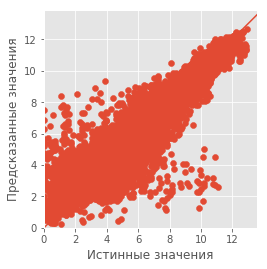

In [35]:
plt.scatter(y_test, y_pred_forest)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Она же на тренировочной выборке. 

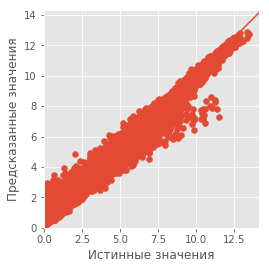

In [36]:
plt.scatter(y_train, rf.predict(X_train))
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Внимательный студент завопит в голос, что лес переобучился, потому что он вытянулся вдоль диагонали на тренировочной выборке, а на тестовой не вытянулся! Студент был бы прав, если бы это был __любой другой алгоритм.__ Случайный лес очень хорош тем, что __он не переобучается.__

У случайного леса, кстати говоря, тоже куча гиперпараметров. И их тоже все можно перебирать. Правда это займёт ещё больше времени, чем в случае регрессии, так как алгоритм обучает много-много деревьев.

## 7. Сохраняем результаты

Сохраняем модели на свой компьютер. На следущем семинаре они нам пригодятся. Мы будем более досканально исследовать их с точки зрения безнес-эффекта. 

In [37]:
from sklearn.externals import joblib

In [38]:
joblib.dump(model_lasso, 'model_lasso.pkl') 

['model_lasso.pkl']

In [39]:
joblib.dump(rf, 'model_rf.pkl') 

['model_rf.pkl']